In [1]:
# Data Structure
import pandas as pd
import numpy as np

import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Scaling
from sklearn.preprocessing import MinMaxScaler

## Importing data into DataFrame

In [2]:
df=pd.read_csv('archive-nifty/SBIN.csv',date_parser=True)

In [3]:
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158,2020-09-24,SBIN,EQ,183.80,181.10,181.80,175.50,176.45,176.35,178.59,46115352,8.235929e+14,286558.0,12700503.0,0.2754
5159,2020-09-25,SBIN,EQ,176.35,179.00,182.75,176.15,182.25,182.20,179.71,46550618,8.365427e+14,213017.0,7170816.0,0.1540
5160,2020-09-28,SBIN,EQ,182.20,184.00,188.15,183.35,187.45,187.25,186.34,41921659,7.811519e+14,195148.0,6606392.0,0.1576
5161,2020-09-29,SBIN,EQ,187.25,188.50,188.95,183.25,185.30,185.05,185.23,35688939,6.610754e+14,146100.0,3785103.0,0.1061


In [4]:
train=df[df['Date']<'2017-01-01']
test=df[df['Date']>='2017-01-01']

## Selecting required features

In [5]:
cols=['Open','High','Low','Close','Volume']
train=train[cols]
test=test[cols]

## Scaling the values with MinMax scaler

In [6]:
scaler=MinMaxScaler()

nTrain=scaler.fit_transform(train)
nTrain.shape

(4235, 5)

## Preparing the dataset

In [7]:
xTrain=[]
yTrain=[]
window=14

for i in range(window,nTrain.shape[0]):
    xTrain.append(nTrain[i-window:i])
    yTrain.append(nTrain[i,0])

xTrain,yTrain=np.array(xTrain),np.array(yTrain)

xTrain.shape,yTrain.shape

((4221, 14, 5), (4221,))

## Class to implement Genetic Algorithm

In [8]:
class GeneticAlgorithm:
    
    def __init__(self, trainData, groundTruth, windowSize=14, populationSize = 10, attributesSize = 5, generations = 100):
        
        # Initialize population randomly
        self.attributesSize = attributesSize
        self.windowSize = windowSize
        self.population = self.initPopulation(attributesSize, populationSize)
        self.logDF = pd.DataFrame(columns = ["Generation","HighestFitness","LowestFitness","AvgFitness"])
        # Evolution
        for generation in range(generations):
            
            # Get the fitness scores of the population
            fitnessScores = self.getFitness(self.population, trainData, groundTruth)
                      
            # Log to DataFrame
            self.logtoDF(generation, self.population, fitnessScores, populationSize)
                
            # Select two parents 
            parent1, parent2 = self.selectParents(self.population, fitnessScores)
            
            # Perform and get children
            child1, child2 = self.crossover(parent1, parent2)
            
            # Create rest of the population by mutation
            self.population = self.fillPopulation(parent1, parent2, child1, child2, populationSize)
            
        self.plotPerformance(self.getlogDF())
    
    def initPopulation(self, attributesSize, populationSize):
        
        # Initialize population randomly
        return [[([random.random() for i in range(attributesSize)]) for j in range(self.windowSize)] for k in range(populationSize)]
    
    def logtoDF(self, generation, population, fitnessScores, populationSize):
        newRow = pd.DataFrame([[generation,max(fitnessScores),min(fitnessScores),(sum(fitnessScores)/populationSize)]],columns=self.logDF.columns)
        self.logDF = self.logDF.append(newRow,ignore_index=True)
        
    def getlogDF(self):
        return self.logDF
    
    def plotPerformance(self,logDF):
        plt.plot(logDF["HighestFitness"],label="Highest Fitness")
        plt.plot(logDF["AvgFitness"],label="Average Fitness")
        plt.plot(logDF["LowestFitness"],label="Lowest Fitness")
        plt.legend()
        plt.title("Algorithm Performance")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.show()
    
    def crossover(self, parent1, parent2):
        
        # Initialising children with parents' values
        child1 = parent1
        child2 = parent2
        
        # Randomly obtaining two points for two point crossover
        x1, x2 = random.sample([i for i in range(self.windowSize)],2)
        y1, y2 = random.sample([i for i in range(self.attributesSize)],2)
        
        # Performing the two point crossover by swapping the values in the inclusice range (point1, point2) 
        for x in range(min(x1,x2),max(x1,x2)+1):
            for y in range(min(y1,y2),max(y1,y2)+1):
                child1[x][y] = parent2[x][y]
                child2[x][y] = parent1[x][y]
            
        return child1, child2
    
    def selectParents(self, population, fitnessScores):
        
        # Sort population with respect to fitness score and return the top two chromosomes.
        return [x[0] for x in sorted(list(zip(population, fitnessScores)),key=lambda x:x[1],reverse=True)[0:2]]
    
    def mutate(self, chromosome):
        # Randomly add or subtract 10% of the value
        return [([(chromosome[j][i] + (random.choice([-1,0,1]) * chromosome[j][i] * 0.1)) for i in range(self.attributesSize)]) for j in range(self.windowSize)]
    
    def sigmoid(self,x):
        return 1/(1 + np.exp(-x))
    
    def willIncrease(self,x):
        if x > 0.5:
            return True
        else:
            return False
        
    def hasIncreased(self,a,b):
        if (b-a) > 0:
            return True
        else:
            return False
        
    def MinMaxSxaler(self,X):
        X_std = (X - min(X) / (max(X) - min(X)))
        return X_std
    
    def getFitness(self, population, trainData, groundTruth):
        fitnessScores = []
        for chromosome in population:
            fitness = 0
            for (features,target) in zip(trainData, groundTruth):
                scaled_outputs = self.MinMaxSxaler(np.multiply(features,np.array(chromosome)).sum(axis=0))
                prediction = self.willIncrease(self.sigmoid(np.sum(scaled_outputs)))
                actual = self.hasIncreased(features[-1][0],target)
                if prediction == actual:
                    fitness += 1
            fitnessScores.append(fitness)
        return fitnessScores
    
    def fillPopulation(self, parent1, parent2, child1, child2, populationSize):
        # Initialize new population with the two children.
        newPopulation = [parent1, parent2, child1, child2]
        
        # Fill the rest of the population by mutation.
        for x in range((populationSize//2)-2):
            newPopulation.extend([self.mutate(newPopulation[-2]), self.mutate(newPopulation[-1])]) 
            
        return newPopulation

## Running the algorithm

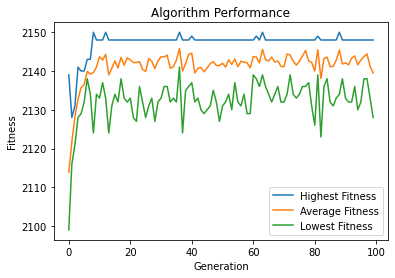

In [9]:
ga = GeneticAlgorithm(trainData=xTrain,groundTruth=yTrain)
logDF = ga.getlogDF()